# 1 - Installs

In [1]:
!pip install kornia 
!pip install fastai
!pip install opencv-python
!pip install imageio
!pip install nibabel
!pip install ipywidgets

# 2 - Imports

In [2]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# 3 - Data preprocessing

In [3]:
 # Create a meta file for the nifti files
    
file_list = []

for dirname, _, filenames in os.walk('D:\Datasets\liverSegmentation\input'):
    for filename in filenames:
        file_list.append((dirname,filename))
        
df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
0,D:\Datasets\liverSegmentation\input\segmentations,segmentation-0.nii
1,D:\Datasets\liverSegmentation\input\segmentations,segmentation-1.nii
2,D:\Datasets\liverSegmentation\input\segmentations,segmentation-10.nii
3,D:\Datasets\liverSegmentation\input\segmentations,segmentation-100.nii
4,D:\Datasets\liverSegmentation\input\segmentations,segmentation-101.nii
...,...,...
227,D:\Datasets\liverSegmentation\input\volume_pt6,volume-95.nii
228,D:\Datasets\liverSegmentation\input\volume_pt6,volume-96.nii
229,D:\Datasets\liverSegmentation\input\volume_pt6,volume-97.nii
230,D:\Datasets\liverSegmentation\input\volume_pt6,volume-98.nii


In [4]:
# Map CT scan and segmentation

df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""

for i in range(int(len(file_list)/2)):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] =  mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = 'D:\Datasets\liverSegmentation\input\segmentations'
    
# delete segmentation rows
df_files = df_files[df_files.mask_filename != ""].sort_values(by=['filename']).reset_index(drop=True)

In [5]:
df_files

,dirname,filename,mask_dirname,mask_filename
0,D:\Datasets\liverSegmentation\input\volume_pt1,volume-0.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-0.nii
1,D:\Datasets\liverSegmentation\input\volume_pt1,volume-1.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-1.nii
2,D:\Datasets\liverSegmentation\input\volume_pt1,volume-10.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-10.nii
3,D:\Datasets\liverSegmentation\input\volume_pt6,volume-100.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-100.nii
4,D:\Datasets\liverSegmentation\input\volume_pt8,volume-101.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-101.nii
...,...,...,...,...
126,D:\Datasets\liverSegmentation\input\volume_pt6,volume-95.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-95.nii
127,D:\Datasets\liverSegmentation\input\volume_pt6,volume-96.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-96.nii
128,D:\Datasets\liverSegmentation\input\volume_pt6,volume-97.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-97.nii
129,D:\Datasets\liverSegmentation\input\volume_pt6,volume-98.nii,D:\Datasets\liverSegmentation\input\segmentations,segmentation-98.nii


In [6]:
def read_nii(fpath):
    """
    Reads in a .nii file and returns a pixel array
    """
    
    scan = nib.load(fpath)
    array = scan.get_fdata()
    array = np.rot90(np.array(array))
    
    return array

In [7]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


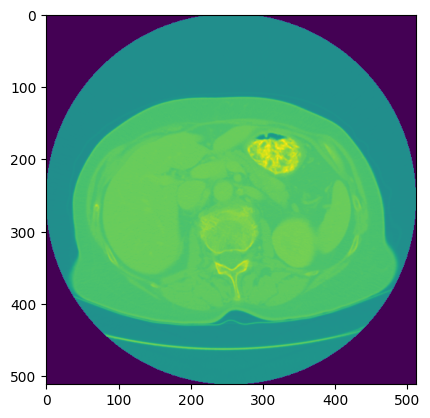

In [11]:
plt.imshow(sample_ct[:,:,55])

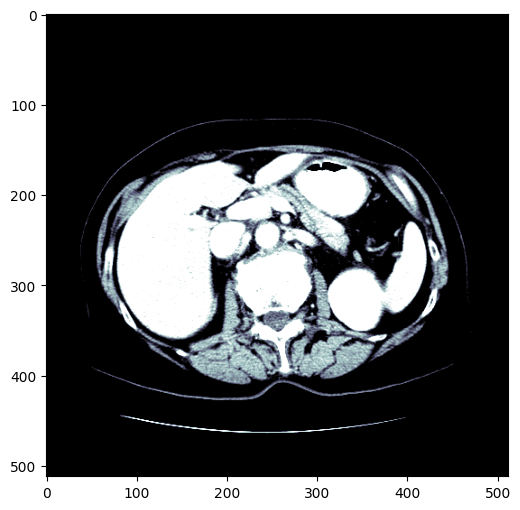

In [12]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [15]:
def plot_sample(array_list : list, color_map = 'nipy_spectral'):
    """
    Plots a slice with all available annotations
    """
    fig = plt.figure(figsize=(20,16), dpi=100)
    
    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

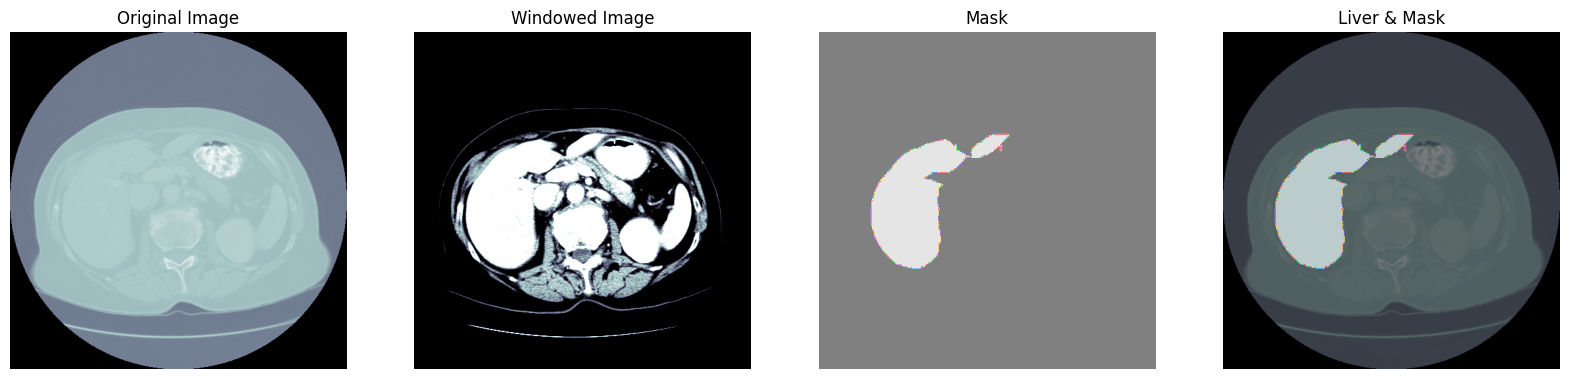

In [16]:
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

<AxesSubplot: >

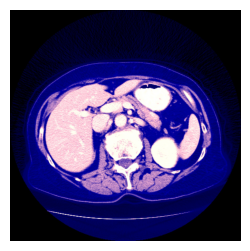

In [30]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging.html

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}
    
@patch
def freqhist_bins(self:Tensor, n_bins = 100):
    """
    Function to split the range of pixel values into groups, such that each group has approximately the same number of pixels.
    """
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    bins = imsd[t].unique()
    return bins

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [33]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path("D:\Datasets\liverSegmentation\preprocessed")

    os.makedirs(os.path.join(path,'train_images'),exist_ok=True)
    os.makedirs(os.path.join(path,'train_masks'),exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"{os.path.join(path,'train_images')}/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"{os.path.join(path,'train_images')}/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]